In [4]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

# Figure S1A: Distribution of QC metrics

Read in scATACseq object to retrive QC metrics per cell barcode. Can be found in Supp table 1, Sheet B. 

In [5]:
obj = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')
obj$ATAC = NULL

# Filter object to QC-passing cells
filtered_obj = subset(obj, broad_celltype_excluded != 'Excluded')

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_50dims_ to umap50dims_"


QC metrics of interest

In [7]:
QC_metrics <- c('FRiP', 'peak_region_fragments', 'TSS.enrichment', 'blacklist_fraction', 'nucleosome_signal', 'doublet_score')


## By originating cohort

In [8]:
# Create long form dataframe of QC metric values by origining cohort
qcdf_final <- map_df(QC_metrics, function(qc) {
  filtered_obj@meta.data %>%
    dplyr::select(cohort, !!sym(qc)) %>%
    rename(value = !!sym(qc)) %>%
    mutate(qcname = qc)
})

Plot density ridge plot

Picking joint bandwidth of 0.00018

Picking joint bandwidth of 0.0146

Picking joint bandwidth of 0.0108

Picking joint bandwidth of 0.0313

Picking joint bandwidth of 881

Picking joint bandwidth of 0.0982



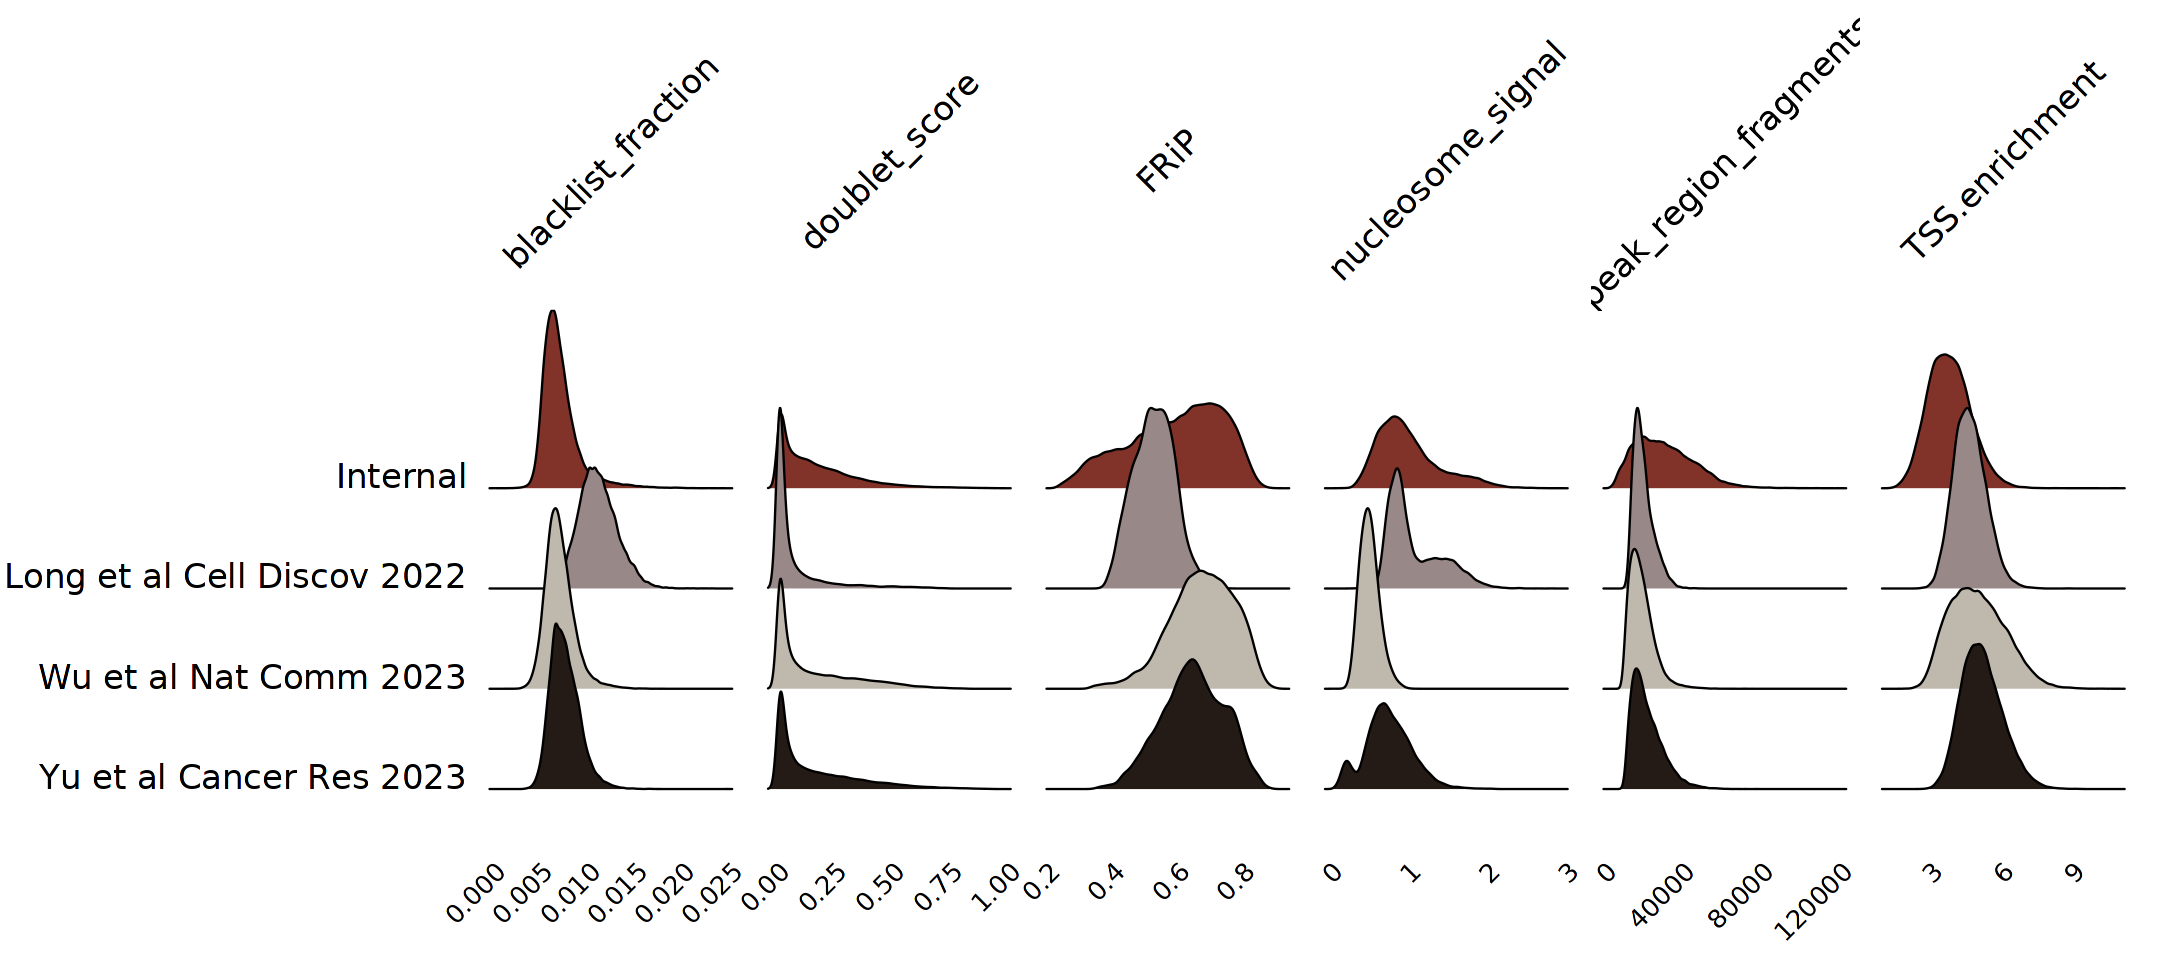

In [9]:
options(repr.plot.width=18, repr.plot.height=8)

# Set colors and order of cohorts
cols = rev(c('#823329', '#998888', '#BFB8AD','#241a16'))
qcdf_final$cohort = factor(qcdf_final$cohort, levels = rev(c('in-house', 'longetal', 'wuetal', 'yuetal')))

# Plot
ggplot(qcdf_final, aes(x = value, y = cohort)) + 
  geom_density_ridges(aes(fill = cohort))  + 
    scale_fill_manual(values = cols) + 
    theme_ridges(grid = FALSE) + 
    theme(axis.text.x = element_text(size = 15, angle = 45, hjust = 1), 
          axis.text.y = element_text(size = 20),axis.title.y=element_blank(), 
          axis.ticks.x = element_blank(), axis.title.x = element_blank(), legend.position = 'none') + 
    facet_grid(. ~ qcdf_final$qcname, scales = 'free') +
    theme(strip.background = element_blank(), strip.text.x = element_text(size = 20, angle = 45)) + 
    scale_y_discrete(labels=rev(c('Internal', 'Long et al Cell Discov 2022','Wu et al Nat Comm 2023', 'Yu et al Cancer Res 2023')))


## By fresh/frozen

Add metadata column `sample_status` indicating whether the sample was processing was from fresh or frozen tissue

In [11]:
filtered_obj@meta.data = filtered_obj@meta.data %>%
  mutate(
    sample_status = case_when(
      grepl("multiome", sample) ~ "Frozen", 
      cohort %in% c("in-house","wuetal") ~ "Frozen",
      cohort %in% c("longetal", "yuetal") ~ "Fresh",
      TRUE ~ "Unknown"
    )
  )

table(filtered_obj@meta.data %>% 
      dplyr::select(cohort, sample, sample_status) %>% 
      distinct() %>% 
      dplyr::select(cohort, sample_status))

          sample_status
cohort     Fresh Frozen
  in-house     0     21
  longetal     3      0
  wuetal       0     25
  yuetal      19      0

Create long form dataframe of QC metric values by fresh/frozen

In [12]:
qcdf_final <- map_df(QC_metrics, function(qc) {
  filtered_obj@meta.data %>%
    dplyr::select(sample_status, !!sym(qc)) %>%
    rename(value = !!sym(qc)) %>%
    mutate(qcname = qc)
})

Plot density ridge plot

Picking joint bandwidth of 0.000182

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0111

Picking joint bandwidth of 0.0288

Picking joint bandwidth of 835

Picking joint bandwidth of 0.0957



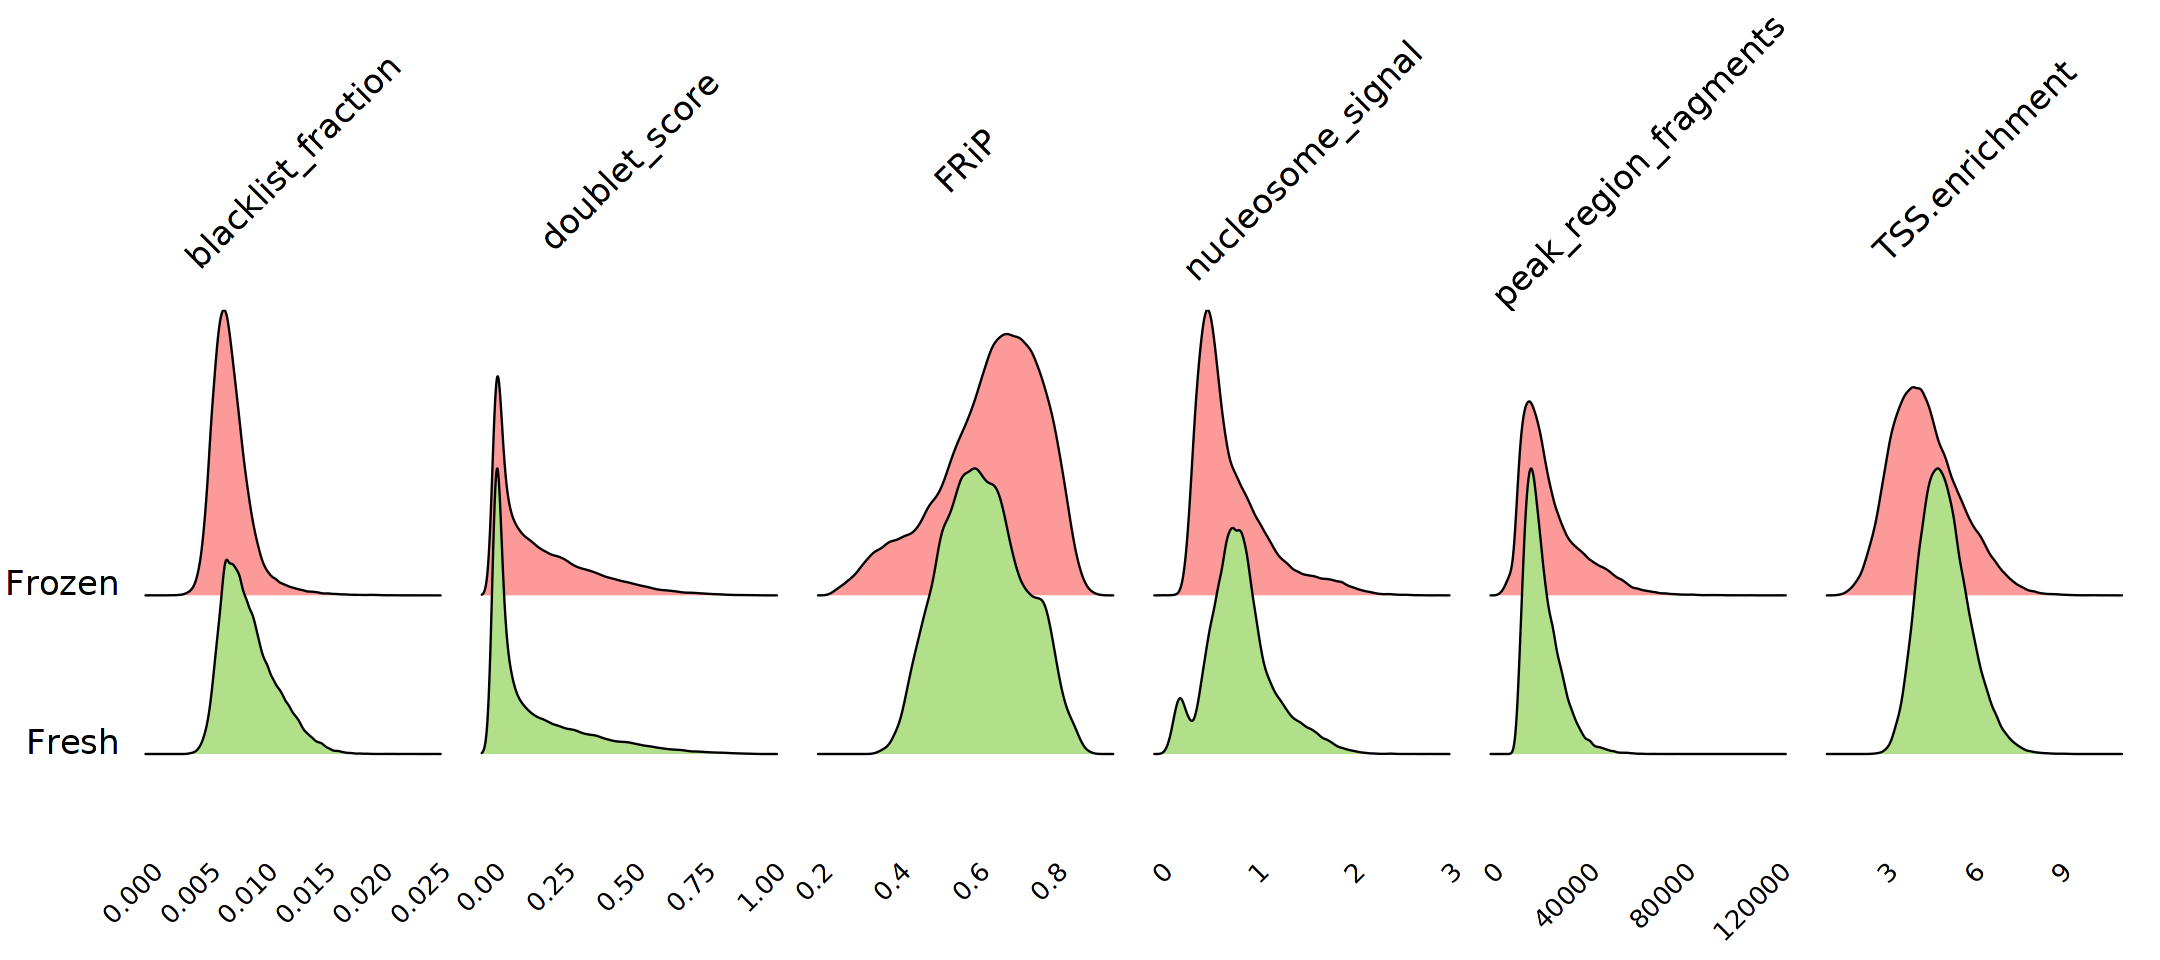

In [13]:
options(repr.plot.width=18, repr.plot.height=8)

# Set colors
cols = c('#b2df8a', '#fb9a99')

ggplot(qcdf_final, aes(x = value, y = sample_status)) + 
    geom_density_ridges(aes(fill = sample_status)) + 
    scale_fill_manual(values = cols) + 
    theme_ridges(grid = FALSE) + 
    theme(axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
          axis.text.y = element_text(size = 20),axis.title.y=element_blank(),
          axis.ticks.x = element_blank(), axis.title.x = element_blank(),
          legend.position = 'none') + 
    facet_grid(. ~ qcdf_final$qcname, scales = 'free') +
    theme(strip.background = element_blank(), strip.text.x = element_text(size = 20, angle = 45))


# Figure S1B: Proportional and count-based stacked bar plots comparing cell type capture

In [14]:
# Set cell type order for plotting
levels = c('Tumor','CD8 T cell','T-helper','T-reg','NK', 'Plasma cell', 'B cell', 
 'TAM','Monocyte','MoDC','cDC','Endothelial','Perivascular cell','Fibroblast')
filtered_obj$broad_celltype_excluded <- factor(filtered_obj$broad_celltype_excluded, levels = c(levels))

# Set colors based on Fig 1 UMAP
celltype_cols <- colorRampPalette(brewer.pal(14, "Accent"))(14)
celltype_cols = c(celltype_cols[14], celltype_cols[-14])

Warning message in brewer.pal(14, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"


## By originating cohort

Proportional

Warning message in brewer.pal(14, "Accent"):
"n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
"


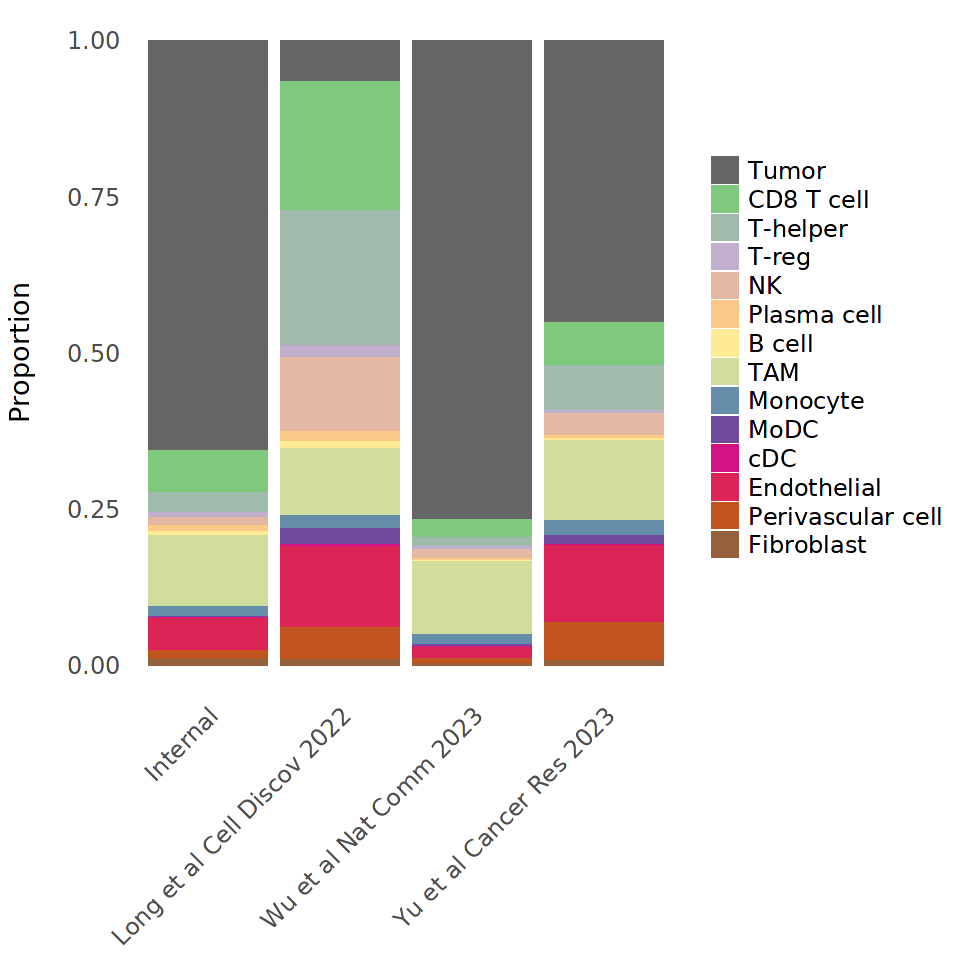

In [12]:
# Calculate proportion of cell type per cohort
df_summary <- filtered_obj@meta.data %>%
  dplyr::count(cohort, broad_celltype_excluded) %>%
  group_by(cohort) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

options(repr.plot.width=8, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = cohort, y = proportion, fill = broad_celltype_excluded)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() + 
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),legend.title = element_blank(),
          legend.text=element_text(size=14), axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(), axis.text.x = element_text(angle = 45, hjust=1, size = 14),
          axis.text.y = element_text(size=14)) + 
    scale_fill_manual(values = celltype_cols) + 
    scale_x_discrete(labels=(c('Internal', 'Long et al Cell Discov 2022','Wu et al Nat Comm 2023', 'Yu et al Cancer Res 2023')))


Counts-based

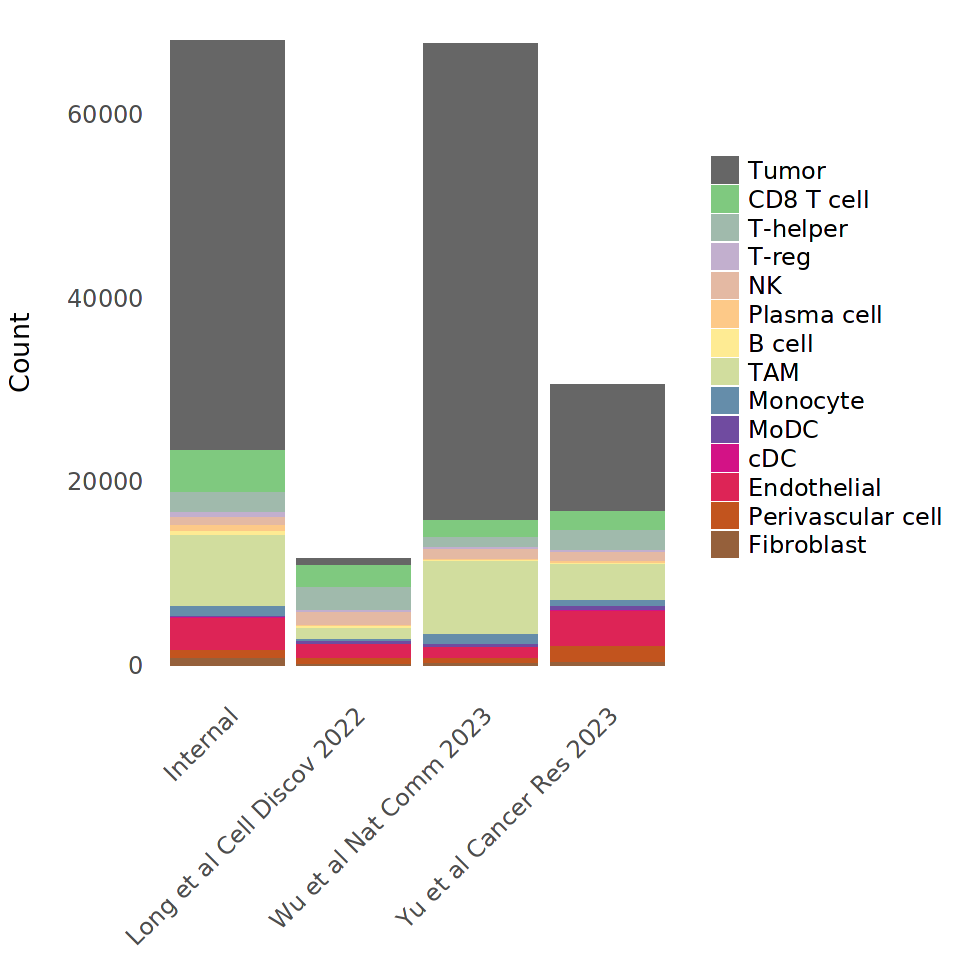

In [15]:
# Calculate raw counts of cells per cell type in each cohort
df_counts <- filtered_obj@meta.data %>%
  dplyr::count(cohort, broad_celltype_excluded)

options(repr.plot.width=8, repr.plot.height=8)
# Generate the plot with counts
ggplot(df_counts, aes(x = cohort, y = n, fill = broad_celltype_excluded)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(y = "Count", x = "Cohort", fill = "Cell Type") + 
  theme_classic() + 
  theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
        legend.title = element_blank(), 
        legend.text = element_text(size = 14), 
        axis.title.x = element_blank(), 
        axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)), 
        axis.ticks = element_blank(), 
        axis.line = element_blank(), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(size = 14)) + 
  scale_fill_manual(values = celltype_cols) +
  scale_x_discrete(labels = c('Internal', 'Long et al Cell Discov 2022', 'Wu et al Nat Comm 2023', 'Yu et al Cancer Res 2023'))


## By fresh/frozen

Proportion

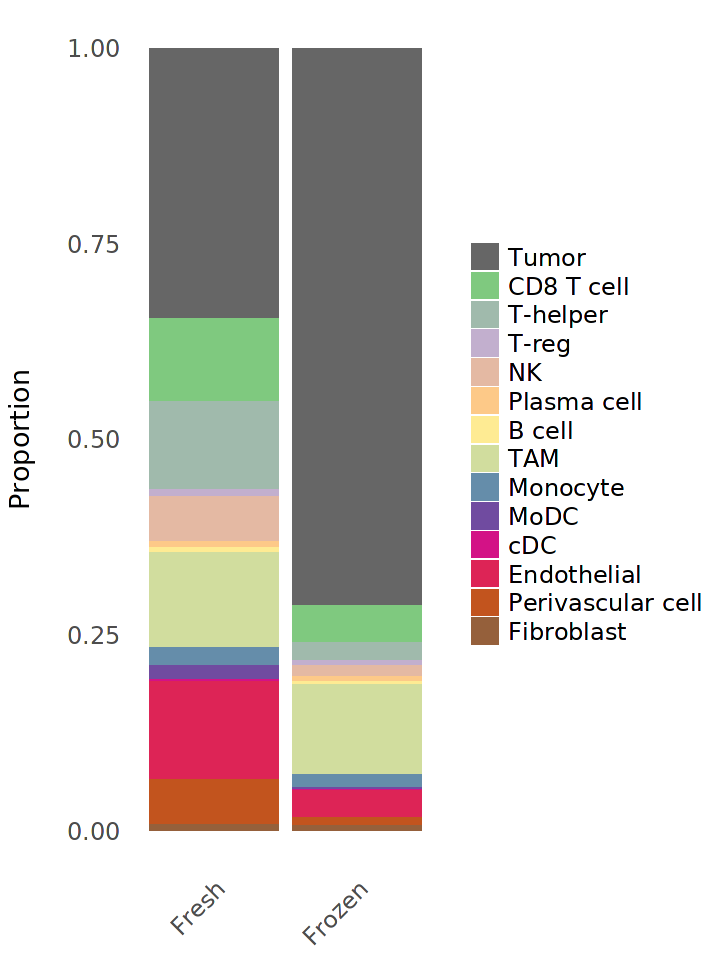

In [16]:
# Calculate proportion of cell type per fresh/frozen
df_summary <- filtered_obj@meta.data %>%
  dplyr::count(sample_status, broad_celltype_excluded) %>%
  group_by(sample_status) %>%
  mutate(proportion = n / sum(n)) %>%
  ungroup()

options(repr.plot.width=6, repr.plot.height=8)
# Create proportional stacked bar plot
ggplot(df_summary, aes(x = sample_status, y = proportion, fill = broad_celltype_excluded)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "Proportion", x = "Cell Type", fill = "Cohort") + 
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5, face = 'plain'),legend.title = element_blank(),
          legend.text=element_text(size=14), axis.title.x=element_blank(),
          axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)),
          axis.ticks=element_blank(), axis.line=element_blank(),
          axis.text.x = element_text(angle = 45, hjust=1, size = 14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = celltype_cols)

Count-based

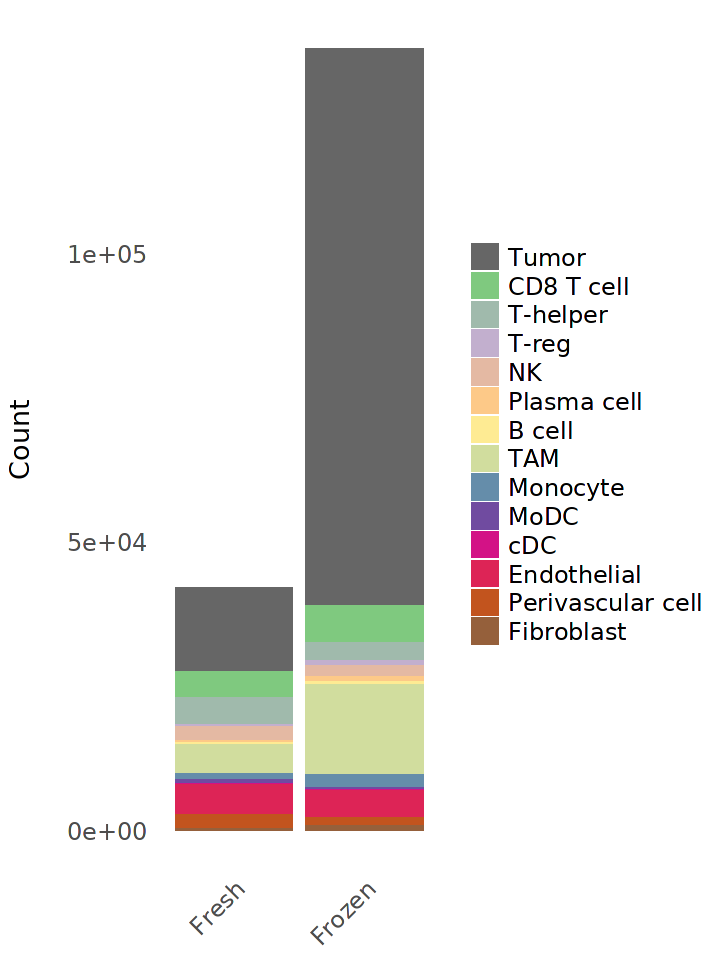

In [17]:
# Calculate number of cells per broad cell type per fresh/frozen
df_counts <- filtered_obj@meta.data %>%
  dplyr::count(sample_status, broad_celltype_excluded)

options(repr.plot.width=6, repr.plot.height=8)
# Generate the plot with counts
ggplot(df_counts, aes(x = sample_status, y = n, fill = broad_celltype_excluded)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(y = "Count", x = "Cohort", fill = "Cell Type") + 
  theme_classic() + 
  theme(plot.title = element_text(hjust = 0.5, face = 'plain'),
        legend.title = element_blank(), 
        legend.text = element_text(size = 14), 
        axis.title.x = element_blank(), 
        axis.title.y = element_text(size = 16, margin = margin(t = 0, r = 20, b = 0, l = 0)), 
        axis.ticks = element_blank(), 
        axis.line = element_blank(), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(size = 14)) + 
  scale_fill_manual(values = celltype_cols) 

# Table S1

In [19]:
setwd('/home/jupyter/scATAC_analysis/edit')

## Sheet A - Mutation information

Table creation in figure 1 notebook. 

In [21]:
# Indicate whether we decided the mutation was pLOF or not
muts = read.table('snatac-rcc-manuscript-data/comut_muts.txt', sep = '\t')
muts = muts %>% filter(value != 'Unable to determine')
muts = muts %>% mutate(pLOF = case_when(
    value %in% c('Missense','In frame indel') ~ 0,
    TRUE ~ 1))

# Set column names
colnames(muts) = c('gene','consequence', 'biopsy','pLOF')

# Have three identifiers - Participant, Biopsy, and Sample level for easy mapping
cell_metadata = filtered_obj@meta.data
muts_w_ids = dplyr::inner_join(muts, cell_metadata %>% 
                               dplyr::select(c('biopsy','sample','participant')) %>% 
                               distinct(), by = 'biopsy')
muts_w_ids = muts_w_ids %>% 
                            dplyr::select(c('participant','biopsy','sample','gene','consequence','pLOF'))
head(muts_w_ids)

# Three samples have no mutation info c('rcc_0600855_T2', 'rcc_0600920_T1','rcc_RCCT1324-T1A'). 
# The other samples can safely assume if mutation not here then its not present
write.table(muts_w_ids, 'snatac-rcc-manuscript-data/s1a_mutations.txt', sep = '\t', quote = F, row.names = F, col.names = T)


Warning message in dplyr::inner_join(muts, cell_metadata %>% dplyr::select(c("biopsy", :
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 26 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


,participant,biopsy,sample,gene,consequence,pLOF
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0600855,rcc_0600855_T3,CCG1114e_0600855_T3_B1_multiome,VHL,Missense,0
2,0600855,rcc_0600855_T3,rcc_0600855_T3,VHL,Missense,0
3,0600855,rcc_0600855_T3,CCG1114e_0600855_T3_B1_multiome,SETD2,Nonsense,1
4,0600855,rcc_0600855_T3,rcc_0600855_T3,SETD2,Nonsense,1
5,0600855,rcc_0600855_T3,CCG1114e_0600855_T3_B1_multiome,KDM5C,Nonsense,1
6,0600855,rcc_0600855_T3,rcc_0600855_T3,KDM5C,Nonsense,1


## Sheet B - Cell metadata

Add in metadata column for dbgap subject IDs for internal cohort

In [22]:
metadata = filtered_obj@meta.data
metadata$cell_barcodes = row.names(metadata)
# Add subject ID
dbgap_subjectID_mapping = read.table('data/inhouse_wu_long_yu/dbgap/object_participant_to_dbgapsubjectid_mapping.txt', sep = '\t', header = TRUE)
cell_metadata = dplyr::left_join(metadata, dbgap_subjectID_mapping, by = 'participant')
# Add sample ID
original_sampleids = unique((cell_metadata %>% filter(cohort == 'in-house'))$sample)
predicted_dbgap_sampleids_v = ifelse(grepl("multiome", original_sampleids),
                                     paste0(original_sampleids, "_ATAC"),
                                     original_sampleids)
predicted_dbgap_sampleids = data.frame(sample = original_sampleids, dbgap_sampleid = predicted_dbgap_sampleids_v)
cell_metadata = dplyr::left_join(cell_metadata, predicted_dbgap_sampleids, by = 'sample')

Determine which subset of object metadata columns will go into supplementary table

In [25]:
# Subset to particular columns
copyscAT_cols = grep('chr',colnames(cell_metadata), value = TRUE)
incl_cols = c('cell_barcodes','sample','biopsy','participant','dbgap_subjectid',
              'dbgap_sampleid','doublet_score', 'male', 'age_at_diagnosis',
             'fuhrman_grade','stage','histology', 'sarcomatoid_features','biopsy_site',
              'sample_status','cohort','broad_celltype_excluded', copyscAT_cols,
              'blacklist_fraction','nucleosome_signal','TSS.enrichment','FRiP',
              'peak_region_fragments')
length(incl_cols)
cell_metadata = cell_metadata %>% dplyr::select(incl_cols)

# Tidy up column names
cell_metadata = cell_metadata %>% rename(cell_type = broad_celltype_excluded, sex = male)

# Rename cohort names to something more understandable
cell_metadata = cell_metadata %>% mutate(
    cohort = case_when(
      cohort ==  "wuetal" ~ "Wu et al Nat Comm 2023", 
      cohort == "longetal" ~ "Long et al Cell Discov 2022",
      cohort == 'yuetal' ~ "Yu et al Cancer Res 2023",
        cohort == 'in-house' ~ "Internal"
    ))
dim(cell_metadata)
head(cell_metadata)
write.table(cell_metadata, file = 'snatac-rcc-manuscript-data/s1b_cell_metadata.txt', sep = '\t', quote = FALSE,row.names = FALSE, col.names = TRUE)

[1] 66

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(incl_cols)

  # Now:
  data %>% select(all_of(incl_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


[1] 177845     66

,cell_barcodes,sample,biopsy,participant,dbgap_subjectid,dbgap_sampleid,doublet_score,sex,age_at_diagnosis,fuhrman_grade,⋯,chrXq,chrYq,chrXp,chr21p,chr22p,blacklist_fraction,nucleosome_signal,TSS.enrichment,FRiP,peak_region_fragments
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,C3L-00004-01_GGGCCATGTTCTACCC-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.123358443,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.008461771,0.5299340,5.189575,0.6240100,29405.81
2,C3L-00004-01_TCACCACGTACAAGCG-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.135753304,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.006627219,0.5445879,5.637728,0.7754665,21505.90
3,C3L-00004-01_TCCCACACACGGTTAT-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.003836718,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.006557855,0.5327389,4.537974,0.5889876,27165.67
4,C3L-00004-01_CCCTCTCGTAAAGGCC-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.118392594,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.007877148,0.5368630,5.393919,0.6296278,23747.05
5,C3L-00004-01_TAGGAGGCAATGTAAG-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.009539410,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.007144404,0.3746113,6.469055,0.8635797,21806.31
6,C3L-00004-01_GCATTGACACCTGTGG-1,C3L-00004-01,C3L-00004-01,C3L-00004,NA,NA,0.002748405,1,72,3,⋯,1.888227,1.793084,NA,NA,NA,0.006280843,0.5012121,6.126800,0.8416614,14113.13


## Sheet C - Differentially accessible genes by non-tumor broad cell type

In [26]:
# Read in unfiltered differentially accessible gene output
dag = readRDS('data/inhouse_wu_long_yu/allcells/findmarkers/nontumor_diffgenes.rds')
# Filter to significant and save
write.table(dag %>% filter(p_val_adj < 0.05), file = 'snatac-rcc-manuscript-data/s1c_nontumor_diffgenes.txt', sep = '\t', quote = F, col.names = T, row.names = F)

## Writing out tables to Excel workbook
Switch to python kernel. 

In [1]:
import pandas as pd

In [2]:
mutations = pd.read_csv('snatac-rcc-manuscript-data/s1a_mutations.txt', sep = '\t')
cell_metadata = pd.read_csv('snatac-rcc-manuscript-data/s1b_cell_metadata.txt', sep = '\t')
dags = pd.read_csv('snatac-rcc-manuscript-data/s1c_nontumor_diffgenes.txt', sep = '\t')

with pd.ExcelWriter('snatac-rcc-manuscript-data/table_S1.xlsx') as writer:  
    mutations.to_excel(writer, sheet_name='A', index = False)
    cell_metadata.to_excel(writer, sheet_name='B', index = False)
    dags.to_excel(writer, sheet_name='C', index = False)
    
# Add README with titles in Excel 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3,4,5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
